Setting up

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from sklearn.manifold import TSNE

# Getting my modules
sys.path.append('/home/jonathak/VisualEncoder/Analysis/Brain_maps')
from NIPS_utils import get_hemisphere_indices, get_roi_indices, get_roi_indices_per_hemisphere

# Setting up GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Appending Roman's path
sys.path.append('/home/romanb/PycharmProjects/BrainVisualReconst/')

Generating voxel embeddings per ROI - run first cell to generate or second cell to load

In [2]:
# Loading the model
encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
model = torch.load('/home/jonathak/VisualEncoder/Voxels_Prediction/model_ch128.pth').eval().cuda()

# Testing voxel embeddings
voxel_embeddings = model.voxel_embed # Has shape [315997, 256]

# Getting subject 1 indices

sub = 1

lh_start, lh_end = get_hemisphere_indices(sub, 'lh')
rh_start, rh_end = get_hemisphere_indices(sub, 'rh')    
sub_indices = np.arange(lh_start, rh_end)

voxel_embeddings = voxel_embeddings[sub_indices]

# # Getting tSNE embeddings
# # ! note that I commented this out for a quick run
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, metric="correlation")
# voxel_embeddings_tsne = tsne.fit_transform(voxel_embeddings.detach().squeeze().cpu().numpy())

Using cache found in /home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main
/home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
# Load tSNE embeddings
voxel_embeddings_tsne = np.load('/home/jonathak/VisualEncoder/DIP_decoder/voxel_embeddings_ROIs/voxel_embeddings_tsne.npy')

In [4]:
sub = 1

# Getting ROI indices

ROIs_bodies = ['EBA', 'FBA-1', 'FBA-2', 'mTL-bodies']
ROIs_faces = ['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']
ROIs_places = ['OPA', 'PPA', 'RSC']
ROIs_words = ['OWFA', 'VWFA-1', 'VWFA-2', 'mfs-words', 'mTL-words']
ROIs_visual = ['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']

ROIs = ROIs_bodies + ROIs_faces + ROIs_places + ROIs_words + ROIs_visual

ROI_indices = {}

# Creating a dictionary of ROI indices (iterating over copy because we remove ROIs that don't exist)
for ROI in ROIs.copy():
    
    roi_indices = get_roi_indices(sub, ROI)
    
    if roi_indices is None:
        ROIs.remove(ROI)
    else:
        ROI_indices[ROI] = roi_indices
        # print(ROI, roi_indices.shape)

# Getting tSNE voxel embeddings for each ROI

ROIs_voxel_embeddings_tsne = {}

for ROI in ROIs:
    ROIs_voxel_embeddings_tsne[ROI] = voxel_embeddings_tsne[ROI_indices[ROI]]
    # print(ROI, ROIs_voxel_embeddings_tsne[ROI].shape)
    

ROI 'mTL-bodies' not found for subject 1
ROI 'mTL-faces' not found for subject 1
ROI 'aTL-faces' not found for subject 1
ROI 'mTL-words' not found for subject 1


# Matanya trying to take average

In [5]:
def get_embedding_based_ROI(indices, voxel_embeddings, threshold=None, top_k=None):
    """
    Get the embedding-based ROI by selecting voxel embeddings close to the mean of a given ROI.
    Can use either a distance threshold or select the top_k closest voxels.
    
    Parameters:
    - indices (Tensor): 1D tensor of voxel indices for the ROI
    - voxel_embeddings (Tensor): [num_voxels, embedding_dim]
    - threshold (float): Optional, distance threshold for inclusion
    - top_k (int): Optional, number of closest voxels to select
    
    Returns:
    - Tensor of selected voxel indices (relative to voxel_embeddings, not indices)
    """
    if threshold is None and top_k is None:
        raise ValueError("Either threshold or top_k must be provided.")
    if threshold is not None and top_k is not None:
        raise ValueError("Only one of threshold or top_k should be provided.")
    
    center_of_mass = voxel_embeddings[indices].mean(dim=0)
    distances = torch.norm(voxel_embeddings - center_of_mass, dim=1)

    if threshold is not None:
        selected_indices = torch.where(distances < threshold)[0]

    elif top_k is not None:
        selected_indices = torch.topk(distances, k=top_k, largest=False).indices

    return center_of_mass, selected_indices


In [6]:
ROI_indices.keys()
# ROI_indices['PPA'].size

dict_keys(['EBA', 'FBA-1', 'FBA-2', 'OFA', 'FFA-1', 'FFA-2', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA-1', 'VWFA-2', 'mfs-words', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4'])

In [7]:
center_of_mass, indeces = get_embedding_based_ROI(ROI_indices['EBA'], voxel_embeddings, top_k=ROI_indices["EBA"].size)
indeces.size()

torch.Size([6237])

In [8]:
print("Intersection between the embedding-based ROI (top-k closest to mean) and real ROI:\n")
print(f"{'ROI':<12} {'% Overlap':>10} {'# Voxels':>17} {'Avg Dist.':>17} {'Std Dev':>10}")
print("-" * 75)

for ROI in ROIs:
    center_of_mass, eb_EBA_indeces = get_embedding_based_ROI(
        ROI_indices[ROI], 
        voxel_embeddings, 
        top_k=ROI_indices[ROI].size  
    )

    # Calculate average distance and std from center of mass
    distances = torch.norm(voxel_embeddings[eb_EBA_indeces] - center_of_mass, dim=1)
    avg_distance = distances.mean().item()
    distances_std = distances.std().item()

    # Compute intersection
    intersection = np.intersect1d(eb_EBA_indeces.cpu().numpy(), ROI_indices[ROI])
    intersection_percentage = intersection.size / ROI_indices[ROI].size * 100

    print(f"{ROI:<12} {intersection_percentage:>9.2f}% {intersection.size:>12} / {ROI_indices[ROI].size:<5} {avg_distance:>13.4f} {distances_std:>10.4f}")

print("-" * 75)
print("Note: Average and std distances are computed from embedding-based ROI to the real ROI's center of mass.")


Intersection between the embedding-based ROI (top-k closest to mean) and real ROI:

ROI           % Overlap          # Voxels         Avg Dist.    Std Dev
---------------------------------------------------------------------------
EBA              32.55%         2030 / 6237         0.8156     0.0475
FBA-1            15.13%          118 / 780          0.6926     0.0274
FBA-2            27.45%          235 / 856          0.7475     0.0377
OFA              28.22%          208 / 737          0.7502     0.0368
FFA-1            32.43%          286 / 882          0.7221     0.0360
FFA-2            35.14%          221 / 629          0.7439     0.0418
OPA              32.32%         1509 / 4669         0.7539     0.0431
PPA              35.79%          788 / 2202         0.7092     0.0374
RSC              67.77%          719 / 1061         0.6484     0.0355
OWFA             44.10%          400 / 907          0.7534     0.0427
VWFA-1           32.28%          574 / 1778         0.7282     0.0372

**Suggestion: There is a mixture of naming here... "Embedding Based ROI", "Synthetic ROI", find a name that is clearer..**

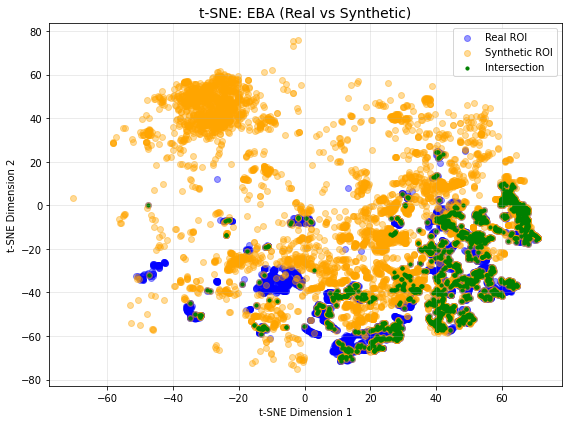

In [9]:
# ROIs_to_plot = ['EBA', 'FFA-1', 'FFA-2', 'PPA', 'V1v']
# ROIs_to_plot = ROIs
ROIs_to_plot = ['EBA']
for ROI in ROIs_to_plot:
    # Get real ROI t-SNE embeddings
    real_tsne = ROIs_voxel_embeddings_tsne[ROI]

    # Get synthetic ROI indices and embeddings
    _, synthetic_indices = get_embedding_based_ROI(ROI_indices[ROI], voxel_embeddings, top_k=ROI_indices[ROI].size)
    synthetic_tsne = voxel_embeddings_tsne[synthetic_indices.cpu().numpy()]  # assume this is the global 2D t-SNE embedding

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(real_tsne[:, 0], real_tsne[:, 1], alpha=0.4, label='Real ROI', color='blue')
    plt.scatter(synthetic_tsne[:, 0], synthetic_tsne[:, 1], alpha=0.4, label='Synthetic ROI', color='orange')

    # Highlight intersection if needed
    intersection = np.intersect1d(synthetic_indices.cpu().numpy(), ROI_indices[ROI])
    if len(intersection) > 0:
        plt.scatter(voxel_embeddings_tsne[intersection][:, 0],
                    voxel_embeddings_tsne[intersection][:, 1],
                    alpha=1.0, color='green', label='Intersection', s=10)

    plt.title(f't-SNE: {ROI} (Real vs Synthetic)', fontsize=14)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


! Matanya's code ends here ! 


Plotting tSNE embeddings for specific ROIs

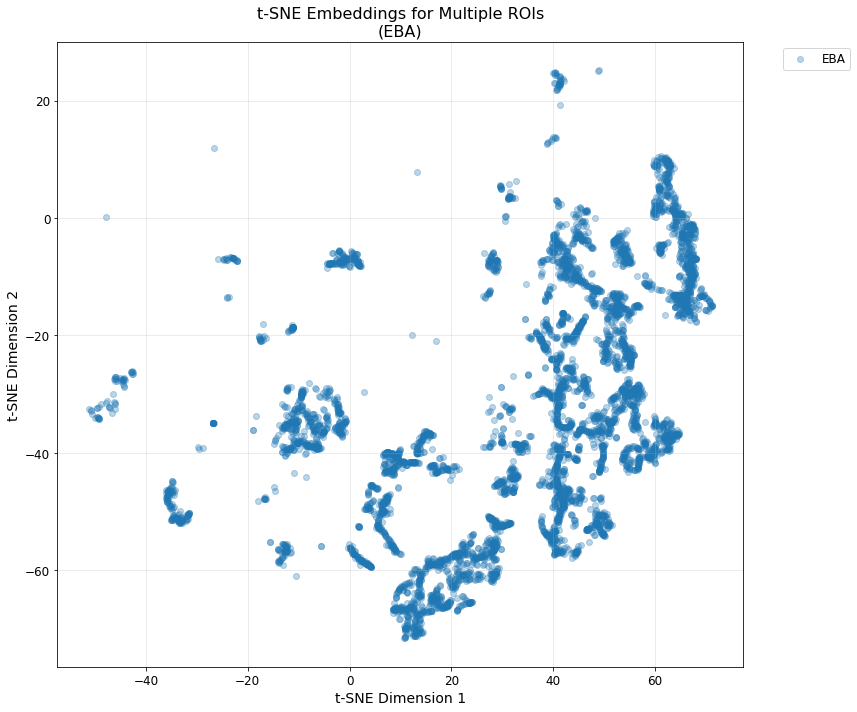

In [13]:
# Define ROIs to plot
ROIs_to_plot = ['EBA']

# ROIs_to_plot = list(set(ROIs).intersection(ROIs_bodies))
# ROIs_to_plot = ROIs

# Create the scatter plot
plt.figure(figsize=(12, 10))

# Create a color map for the ROIs
# colors = plt.cm.tab20(np.linspace(0, 1, len(ROIs_to_plot)))
# colors = [plt.cm.tab20(0)]*len(ROIs_to_plot)
colors = plt.cm.tab20.colors[:len(ROIs_to_plot)]


# Plot each ROI with a different color
for ROI, color in zip(ROIs_to_plot, colors):
    plt.scatter(ROIs_voxel_embeddings_tsne[ROI][:, 0], 
               ROIs_voxel_embeddings_tsne[ROI][:, 1],
            #    alpha=0.6,
               alpha=0.3,
               label=ROI,
               color=color)

# Set title and labels with larger font sizes
plt.title(f't-SNE Embeddings for Multiple ROIs\n({", ".join(ROIs_to_plot)})', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)

# Add legend
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# Increase tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# ... existing code ...

In [ ]:
# Define ROIs to plot for each subplot
ROIs_to_plot_1 = ['FFA-1']
ROIs_to_plot_2 = list(set(ROIs).intersection(ROIs_faces))  # Example for second plot

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Colors for each subplot
# colors1 = [plt.cm.tab20(0)]*len(ROIs_to_plot_1)
# colors2 = [plt.cm.tab20(0)]*len(ROIs_to_plot_2)  # Different color for second plot
colors1 = plt.cm.tab20.colors[:len(ROIs_to_plot_1)]
colors2 = plt.cm.tab20.colors[:len(ROIs_to_plot_2)]

# First subplot
for ROI, color in zip(ROIs_to_plot_1, colors1):
    ax1.scatter(ROIs_voxel_embeddings_tsne[ROI][:, 0], 
               ROIs_voxel_embeddings_tsne[ROI][:, 1],
               alpha=0.6,
               label=ROI,
               color=color)

# Second subplot
for ROI, color in zip(ROIs_to_plot_2, colors2):
    ax2.scatter(ROIs_voxel_embeddings_tsne[ROI][:, 0], 
               ROIs_voxel_embeddings_tsne[ROI][:, 1],
               alpha=0.6,
               label=ROI,
               color=color)

# Set titles and labels for first subplot
ax1.set_title(f't-SNE Embeddings for ROIs:\n({", ".join(ROIs_to_plot_1)})', fontsize=16)
ax1.set_xlabel('t-SNE Dimension 1', fontsize=14)
ax1.set_ylabel('t-SNE Dimension 2', fontsize=14)
ax1.tick_params(labelsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# Set titles and labels for second subplot
ax2.set_title(f't-SNE Embeddings for ROIs:\n({", ".join(ROIs_to_plot_2)})', fontsize=16)
ax2.set_xlabel('t-SNE Dimension 1', fontsize=14)
ax2.set_ylabel('t-SNE Dimension 2', fontsize=14)
ax2.tick_params(labelsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

Clustering using DBSCAN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Optional: if you want to use UMAP for dimensionality reduction
try:
    from umap import UMAP
except ImportError:
    UMAP = None
    print("UMAP is not installed. To use UMAP, install it via 'pip install umap-learn'.")


class HighDimDBSCANCluster:
    def __init__(self, reduction_method=None, n_components=None, eps=0.5, min_samples=5):
        """
        Initialize the clustering object.
        
        Parameters:
        - reduction_method: str, either 'pca' or 'umap'. Set to None for no reduction.
        - n_components: int, the number of dimensions to reduce to if using dimensionality reduction.
        - eps: float, the maximum distance between two samples for them to be considered neighbors.
        - min_samples: int, the number of samples required to form a core point in DBSCAN.
        """
        self.reduction_method = reduction_method
        self.n_components = n_components
        self.eps = eps
        self.min_samples = min_samples
        
        self.scaler = StandardScaler()
        self.reduction_model = None
        self.dbscan_model = None
        
        # Results storage
        self.labels_ = None
        self.clustered_data_ = None
        self.num_clusters_ = None
        self.num_outliers_ = None

    def normalize_data(self, data):
        """Normalize the data using StandardScaler."""
        return self.scaler.fit_transform(data)

    def reduce_dimensions(self, data):
        """
        Reduce dimensions using the specified method.
        
        Parameters:
        - data: normalized data.
        
        Returns:
        - The dimensionally reduced data.
        """
        if self.reduction_method is None:
            return data
        if self.n_components is None:
            raise ValueError("n_components must be specified when using dimensionality reduction.")

        if self.reduction_method.lower() == 'pca':
            self.reduction_model = PCA(n_components=self.n_components)
        elif self.reduction_method.lower() == 'umap':
            if UMAP is None:
                raise ImportError("UMAP is not installed. Install it via 'pip install umap-learn'.")
            self.reduction_model = UMAP(n_components=self.n_components)
        else:
            raise ValueError("Reduction method must be either 'pca' or 'umap'.")

        return self.reduction_model.fit_transform(data)

    def preprocess_data(self, data):
        """
        Preprocess the data by normalizing and, if specified, reducing its dimensions.
        
        Parameters:
        - data: the raw data (numpy array).
        
        Returns:
        - Processed data ready for clustering or analysis.
        """
        normalized_data = self.normalize_data(data)
        if self.reduction_method is not None:
            processed_data = self.reduce_dimensions(normalized_data)
        else:
            processed_data = normalized_data
        return processed_data

    def plot_k_distance(self, data, show=True):
        """
        Generate and optionally display a k-distance plot for the processed data.
        The plot shows, for each data point, the distance to its kth nearest neighbor
        (with k = min_samples). This helps in visually selecting a good eps value.
        
        Parameters:
        - data: raw data (numpy array) that will be preprocessed.
        - show: bool, if True, the plot is displayed.
        
        Returns:
        - sorted_k_distances: The sorted kth nearest neighbor distances.
        """
        processed_data = self.preprocess_data(data)
        # Use min_samples as k (note: the first neighbor is the point itself)
        neighbors = NearestNeighbors(n_neighbors=self.min_samples)
        neighbors.fit(processed_data)
        distances, indices = neighbors.kneighbors(processed_data)
        # For each point, take the distance to its kth (min_samples-th) neighbor.
        k_distances = distances[:, self.min_samples - 1]
        sorted_k_distances = np.sort(k_distances)
        
        if show:
            plt.figure(figsize=(8, 4))
            plt.plot(sorted_k_distances)
            plt.xlabel("Points sorted by distance")
            plt.ylabel(f"Distance to {self.min_samples}-th nearest neighbor")
            plt.title("k-Distance Plot")
            plt.grid(True)
            plt.show()
        
        return sorted_k_distances

    def run_dbscan(self, processed_data):
        """
        Run DBSCAN on the provided (preprocessed) data.
        
        Parameters:
        - processed_data: data on which to run clustering.
        
        Returns:
        - The cluster labels from DBSCAN.
        """
        self.dbscan_model = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        self.labels_ = self.dbscan_model.fit_predict(processed_data)
        return self.labels_

    def cluster(self, data, plot_k_distance=False):
        """
        Execute the full clustering pipeline:
         1. Preprocess the data (normalize and optionally reduce dimensions).
         2. Optionally generate the k-distance plot for parameter analysis.
         3. Run DBSCAN clustering.
         4. Compute the number of clusters and outliers.
         
        Parameters:
        - data: numpy array of shape (N, 256) or similar.
        - plot_k_distance: bool, if True, generates and shows the k-distance plot before clustering.
        
        Returns:
        - The DBSCAN labels for each data point.
        """
        # Preprocess data (normalize and reduce dimensions if needed)
        processed_data = self.preprocess_data(data)
        
        # Optionally display the k-distance plot for parameter estimation.
        if plot_k_distance:
            print("Displaying k-distance plot for analysis. Adjust eps accordingly before clustering.")
            self.plot_k_distance(data, show=True)
        
        # Run DBSCAN clustering
        labels = self.run_dbscan(processed_data)
        
        # Calculate number of clusters (exclude noise which is labeled as -1)
        unique_labels = set(labels)
        if -1 in unique_labels:
            unique_labels.remove(-1)
        self.num_clusters_ = len(unique_labels)
        self.num_outliers_ = list(labels).count(-1)
        
        # Store the clustered data (only the in-cluster points)
        self.clustered_data_ = {label: data[labels == label] for label in unique_labels}
        return labels

    def get_results(self):
        """
        Retrieve the clustering results.
        
        Returns:
        A dictionary containing:
         - 'labels': The cluster labels for each data point.
         - 'num_clusters': The total number of clusters (excluding noise).
         - 'num_outliers': The number of outlier points (noise).
         - 'clustered_data': A dictionary mapping each cluster label to its data points.
        """
        return {
            'labels': self.labels_,
            'num_clusters': self.num_clusters_,
            'num_outliers': self.num_outliers_,
            'clustered_data': self.clustered_data_
        }


In [ ]:
# -------------------------
# Example of how to use the class
# -------------------------
if __name__ == '__main__':
    # Create dummy data: a numpy array with shape (1000, 256)
    np.random.seed(42)
    dummy_data = np.random.rand(1000, 256)
    
    # Initialize the clustering object.
    # Here, we choose to reduce dimensions using PCA to 50 dimensions.
    clusterer = HighDimDBSCANCluster(reduction_method='pca', n_components=50, eps=0.5, min_samples=5)
    
    # Optionally, generate the k-distance plot to help choose eps.
    # (You can inspect the plot and adjust the 'eps' parameter if needed.)
    clusterer.plot_k_distance(dummy_data)
    
    # Now, run clustering on the dummy data
    labels = clusterer.cluster(dummy_data)
    
    # Retrieve and print the results
    results = clusterer.get_results()
    print("Number of clusters (excluding noise):", results['num_clusters'])
    print("Number of outliers:", results['num_outliers'])
